In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords 
from nltk import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import sklearn.utils

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier as mlp

In [2]:
df = pd.read_csv('mbti_1.csv')
mbti = {'I':'Introversion', 'E':'Extroversion', 'N':'Intuition', 
        'S':'Sensing', 'T':'Thinking', 'F': 'Feeling', 
        'J':'Judging', 'P': 'Perceiving'}

### Balancing each paragraph by splitting it to 5 sentences per paragraph. It is believed that 5 sentences per paragrah contain balanced context

In [6]:
def divide(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]
    return l

number_of_lines = 5

length = len(df)
data = []
for i in range(length):
    #if i > 5:
    #    break
    #i += 1
    mytype = df.iloc[i]['type']
    row = df.iloc[i]['posts']
    lines = row.split('|||')
    paragraphs = divide(lines, number_of_lines)
    
    for paragraph in paragraphs:
        new_row = [mytype, paragraph[0]]
        data.append(new_row)

data = pd.DataFrame(data)
data.columns = ['type', 'posts']

In [8]:
def sentence_and_words(text):
    cachedStopWords = stopwords.words("english")
    
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    words = ""
    line = 0
    total_words = 0
    
    for item in text.split('|||'):
        sentence = item.strip()
        sentence = re.sub("[^a-zA-Z]", " ", sentence)
        sentence = re.sub(' +', ' ', sentence).lower()
        
        if sentence and len(sentence) > 1:
            line += 1
            
            new_words = [stemmer.stem(lemmatizer.lemmatize(w.strip())) for w in sentence.split(' ') 
                         if w.strip() not in cachedStopWords and len(w.strip()) > 1]
            
            total_words += len(new_words)
            words += " ".join([w for w in new_words])
            #print(new_words)
    return line, total_words, words

### Cleaning the dataset by removing stop words, removing urls, stemming, and lemmatizing

In [10]:
data['sentences'] = 0
data['total_words'] = 0
data['total_urls'] = 0
data['words'] = 0

total_rows = len(data)

for i in range(total_rows):
    mbti_type = data.iloc[i]['type']
    text = data.iloc[i]['posts']
    
    urls = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',  text)
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)
    
    total_sentence, total_words, words = sentence_and_words(text)
    #print(words)
    data.loc[data.index == i, 'sentences'] = total_sentence
    data.loc[data.index == i, 'total_words'] = total_words
    data.loc[data.index == i, 'total_urls'] = len(urls)
    data.loc[data.index == i, 'words'] = words

In [19]:
indices = data[data['sentences'] == 0].index
data = data.drop(data.index[indices])

### Basic functionality for generating confusion matrix

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
mbti_types = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']

mbti_types_encoder = LabelEncoder().fit(mbti_types)

## Dividing dataset to train and test set 

In [25]:
all_data = sklearn.utils.shuffle(data).reset_index(drop=True)
all_data = sklearn.utils.shuffle(all_data).reset_index(drop=True)
all_data = sklearn.utils.shuffle(all_data).reset_index(drop=True)

all_data = all_data[['type', 'posts', 'sentences', 'total_words', 'words', 'total_urls']]

length = len(all_data)
train_data_len = np.floor(length * 0.8).astype(int)

train_data = all_data.head(train_data_len)
test_data = all_data.tail(length - train_data_len)

In [26]:
len(train_data)

65655

In [27]:
len(test_data)

16414

In [18]:
#all_data['type']

# Multinomial Naive Bayes with Count Vectorization

### Convert a collection of text documents to a matrix of token counts

In [28]:
np.random.seed(1)
tf_idf_similarity = CountVectorizer(ngram_range=(1, 1), stop_words='english', lowercase = True, max_features = 5000)

### Applying the multinomial Naive Bayes and cross validating the model

In [29]:
mn_nb_model = Pipeline([('tf_idf_similarity', tf_idf_similarity), ('mn_nb_model', MultinomialNB())])
num_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
mn_nb_results = cross_validate(mn_nb_model, all_data['words'], all_data['type'], cv=num_folds, n_jobs=-1)

### Accuarcy of multinomial Naive Bayes with CountVectorizer

In [30]:
np.mean(mn_nb_results['test_score'])

0.24520814399822172

### Predict the labels

In [31]:
predicted_labels = cross_val_predict(mn_nb_model, all_data['words'], all_data['type'], cv = num_folds)

In [32]:
predicted_labels

array(['INFP', 'ENTP', 'INFJ', ..., 'ISFP', 'INFP', 'INFP'], 
      dtype='<U4')

### Plot the confusion matrix

Confusion matrix


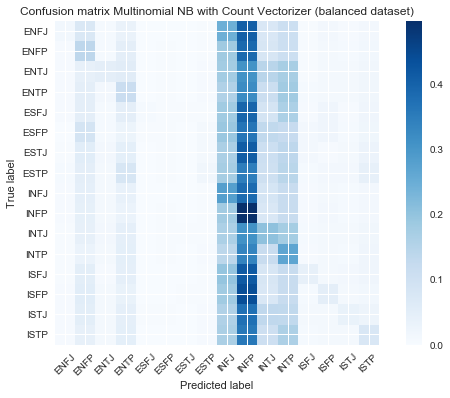

In [33]:
actual_labels = all_data['type'].tolist()
cnf_matrix = metrics.confusion_matrix(actual_labels, predicted_labels)
np.set_printoptions(precision=2)
# Plot confusion matrix
plt.figure(4)
#fig_i += 1
plot_confusion_matrix(cnf_matrix, classes=mbti_types_encoder.inverse_transform(range(16)), normalize=True,
                                          title=('Confusion matrix Multinomial NB with Count Vectorizer (balanced dataset)'))
plt.savefig('confusion_matrix_mnb_count_vectorizer_balanced.png', dpi=100)
#plt.savefig('confusion_matrix_naive_bayes.png', bbox_inches='tight', dpi=100)
plt.show()

# Logistic Regression with Count Vectorization

### Applying logistic regression and cross validating the model

In [34]:
logistic = LogisticRegression(class_weight="balanced", C=0.005)
logistic_model = Pipeline([('tf_idf_similarity', tf_idf_similarity), ('logistic_model', logistic)])
num_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
logistic_results = cross_validate(logistic_model, all_data['words'], all_data['type'], cv=num_folds, n_jobs=-1)

### Accuarcy of logistic regression model with CountVectorizer

In [35]:
np.mean(logistic_results['test_score'])

0.20566857690848589

### Predict the labels

In [36]:
predicted_labels = cross_val_predict(logistic_model, all_data['words'], all_data['type'], cv = num_folds)
predicted_labels

array(['INTP', 'ENTP', 'INFJ', ..., 'ESTP', 'INTP', 'ESTJ'], dtype=object)

### Plot the confusion matrix

Confusion matrix


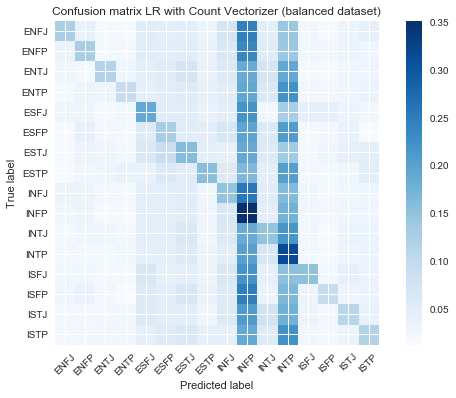

In [37]:
actual_labels = all_data['type'].tolist()
cnf_matrix = metrics.confusion_matrix(actual_labels, predicted_labels)
np.set_printoptions(precision=2)

plt.figure(5)
#fig_i += 1
plot_confusion_matrix(cnf_matrix, classes=mbti_types_encoder.inverse_transform(range(16)), normalize=True,
                                          title=('Confusion matrix LR with Count Vectorizer (balanced dataset)'))
plt.savefig('confusion_matrix_lr_vectorizer_balanced.png', dpi=100)
#plt.savefig('confusion_matrix_naive_bayes.png', bbox_inches='tight', dpi=100)
plt.show()

# Multilayer Perceptron with with Count Vectorization

### Applying multilayer percentron and cross validating the model

In [ ]:
mlp_model = mlp(solver='lbfgs', activation='logistic', alpha=1e-5, hidden_layer_sizes=(20, 6), 
            random_state=1, max_iter=500)
mlp_model = Pipeline([('tf_idf_similarity', tf_idf_similarity), ('mlp_model', mlp_model)])
num_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
mlp_results = cross_validate(mlp_model, all_data['words'], all_data['type'], cv=num_folds, n_jobs=-1)

### Accuarcy of logistic regression model with CountVectorizer

In [ ]:
np.mean(mlp_results['test_score'])

### Predict the labels

In [ ]:
predicted_labels = cross_val_predict(mlp_model, all_data['words'], all_data['type'], cv = num_folds)
predicted_labels

### Plot the confusion matrix

In [ ]:
actual_labels = all_data['type'].tolist()
cnf_matrix = metrics.confusion_matrix(actual_labels, predicted_labels)
np.set_printoptions(precision=2)
# Plot confusion matrix
plt.figure(5)
#fig_i += 1
plot_confusion_matrix(cnf_matrix, classes=mbti_types_encoder.inverse_transform(range(16)), normalize=True,
                                          title=('Confusion matrix MLP with Count Vectorizer (balanced dataset)'))
plt.savefig('confusion_matrix_mlp_count_vectorizer_balanced.png', dpi=100)
#plt.savefig('confusion_matrix_naive_bayes.png', bbox_inches='tight', dpi=100)
plt.show()